In [7]:
pip install lyricsgenius

  Using cached https://files.pythonhosted.org/packages/4a/47/5aba67735bf3b7f2b1f4c1e5d1f9892050847e27e7fafdec14fc72d41bc1/lyricsgenius-1.8.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9e/d4/10f46e5cfac773e22707237bfcd51bbffeaf0a576b0a847ec7ab15bd7ace/beautifulsoup4-4.6.0-py3-none-any.whl
  Found existing installation: beautifulsoup4 4.8.0
    Uninstalling beautifulsoup4-4.8.0:
      Successfully uninstalled beautifulsoup4-4.8.0
Note: you may need to restart the kernel to use updated packages.


In [143]:
import lyricsgenius as genius
import pandas as pd
import matplotlib as plt
import json

In [1]:
class hiphop():
    ''' Class that interfaces with LyricsGenius and ensures outputs for multiple Artists saved in a single file
    called compendium.json
    '''
    import lyricsgenius as genius
    import os
    
    def __init__(self, client_access_token, ArtistsMaxSongNumberz):
        import lyricsgenius as genius
        import os
        #self.client_access_token = client_access_token
        #self.api = genius.Genius(self.client_access_token,
        #         response_format='plain', timeout=5, sleep_time=0.5,
        #         verbose=True, remove_section_headers=False,
        #         skip_non_songs=True, excluded_terms=[],
        #         replace_default_terms=False)
        #assert isinstance(ArtistsMaxSongNumberz, dict), "Only dictionaries with artist-max_song_number pairs accepted"
        self.ArtistsMaxSongNumbers = ArtistsMaxSongNumberz
        self.compendium = {}
        self.dict_for_pandas ={}
        
    
    def add_artists_and_songs(self):
        '''
        Adds artists and their song (or where artists already exist their additional songs) to the compendium of artist information and songs
        '''
        import os
        import json
        
        skip, count = False, 0
        for talent in self.ArtistsMaxSongNumbers.keys():
            if (talent in self.compendium.keys()) and (len(self.compendium[talent]['songs']) == self.ArtistsMaxSongNumbers[talent]):
                print("{} of {}'s songs are already captured in compendium as required. No need to re-search. Leave as is ".format(self.ArtistsMaxSongNumbers[talent], talent))
                count+= 1
                if count == len(self.ArtistsMaxSongNumbers.keys()):
                    skip = True
                continue
            artist = self.api.search_artist(talent, max_songs=self.ArtistsMaxSongNumbers[talent])
            if talent != artist.name:
                print('changing search parameter {} to artist name as found {}'.format(talent, artist.name))
            artist._body['songs'] = [song._body for song in artist.songs]
            self.compendium[artist.name] = artist._body
        
        if skip:
            print('Songs of all the specified artists are already captured in compendium. No update or addition required')
            return None
        else:
            filename = 'compendium.json'
            if input("{} ready to save. Save to file?\n(y/n): ".format(filename)).lower() == 'n':
                return self.compendium
            elif os.path.isfile(filename) and input("file {} already exists. Overwrite?\n(y/n): ".format(filename)).lower() == 'n':
                print('aborting overwrite and returning compendium as dictionary')
                return self.compendium
            else:
                with open(filename, "w") as ff:
                    json.dump(self.compendium, ff, indent=1)
                return self.compendium
    
    
    def resume_after_disconnection(self):
        '''
        to resume song search and addition following an api call disconnected (with Timeout error) without having 
        to re-search for artists and songs previously completed before the api call drop / termination
        '''
        self.add_artists_and_songs()

    def output_result(self, filepath=None):
        '''
        Output a dataframe with the required parameters from the dictionary returned by add_artists_and_songs() method 
        or gotten the file compendium.json saved by add_artists_and_songs() method
        
        It also converts the compendium into a dicitionary of LyricsGenius Artist objects and Song objects
        such that the LyricsGenius methods can be used on any of these objects to simplify manipulation if required. 
        A get_compendium method is later on provided to enable this compendium attribute to be retrieved on demand
        '''
        import os
        import json
        import pandas as pd
        
        if filepath:
            if os.path.isfile(filepath):
                with open(filepath, 'r') as fd:
                    self.compendium = json.load(fd)
            else:
                print('{}is not a valid file path. Please provide another filepath'.format(filepath))
                return None
        
        for talent in self.compendium.keys():
            self.compendium[talent] = genius.artist.Artist({'artist': self.compendium[talent]})
            for work in self.compendium[talent]._body['songs']:
                lyrics = work.pop('lyrics')
                track = genius.song.Song(work, lyrics)
                self.compendium[talent].add_song(track)
            
        self.dict_for_pandas['Artist_name'] = [self.compendium[talent].name for talent in self.compendium.keys() for work in self.compendium[talent].songs]
        self.dict_for_pandas['Album_name'] = [work.album for talent in self.compendium.keys() for work in self.compendium[talent].songs]
        self.dict_for_pandas['Album_date'] = [work.year for talent in self.compendium.keys() for work in self.compendium[talent].songs]
        self.dict_for_pandas['Song_name'] = [work.title for talent in self.compendium.keys() for work in self.compendium[talent].songs]
        self.dict_for_pandas['Song_lyrics'] = [work.lyrics for talent in self.compendium.keys() for work in self.compendium[talent].songs]
            
        return pd.DataFrame.from_dict(self.dict_for_pandas)

In [2]:
result = hiphop(1, 1)

In [11]:
table = result.output_result(filepath="/Users/emekanwosu/Desktop/Own_Coding_Projects/RapGenius/lyrics/compendium.json")

In [12]:
table

,Artist_name,Album_name,Album_date,Song_name,Song_lyrics
0,Arabian Prince,Where’s My Bytches,None,Where Ya Been Bytch,"[Chorus:] Where ya been bitch, where ya been b..."
1,Arabian Prince,None,1989-11-28,She’s Got A Big Posse,[Skit: Announcer + Arabian Prince]\n\nGood mor...
2,Arabian Prince,Brother Arab,1989-11-28,Get On Up,"Rollin, everybody dance with the soul and\nI'm..."
3,Arabian Prince,Brother Arab,None,It’s a Dope Thang,"Wakin up, to the sound I'm boomin\nFrom the br..."
4,Arabian Prince,Brother Arab,1989-11-28,Let the Good Times Roll (Nickel Bag),"Life is a jungle, I'm a hunter who's lossin\nI..."
...,...,...,...,...,...
117420,XXXTENTACION,None,2018-03-16,Pain = BESTFRIEND (OG),"[Verse: XXXTENTACION]\nLost in regret, I\nFeel..."
117421,XXXTENTACION,None,None,Moonlight (Clean),"[Intro]\nYeah\n\n[Chorus]\nSpotlight, uh, moon..."
117422,XXXTENTACION,None,None,Toxic (Self Made Beat 1),[Instrumental]
117423,XXXTENTACION,None,2015-04-10,RUN UP ON ME (ORIGINAL),Yeah\nFuck you niggas talkin' 'bout?\nFuck!\nF...


In [48]:
word_list= pd.read_csv("/Users/emekanwosu/Desktop/Own_Coding_Projects/RapGenius/word_dict/dictionary/popular.txt",delimiter=',')

In [64]:
word_list.columns = ['words']
word_list['words']

0        aardvark
1           aargh
2           aback
3          abacus
4         abandon
           ...   
25316      zoning
25317      zonked
25318         zoo
25319        zoom
25320     zooming
Name: words, Length: 25321, dtype: object

In [52]:
tester = table['Song_lyrics'][0]

In [167]:
def isEnglish(x):
    punc2remove = ['{', '}', '[', ']', ':', '.', ';', '"', '(', ')', ',', '!', '&', '$', '#', '@', '?', '*']
    punc_remover = {ord(i): None for i in punc2remove}
    if x:
        inpt = x.lower()
        punc_removed = inpt.translate(punc_remover)
        listz = pd.Series(punc_removed.split())
        return listz.isin(word_list['words']).mean()
    else:
        return 0.0


In [164]:
table['isEnglish'] = table['Song_lyrics'].apply(isEnglish)

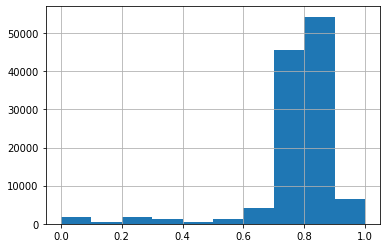

In [166]:
table['isEnglish'].hist()

In [168]:
table.loc[(table['isEnglish'] < 0.5) & (table['isEnglish'] > 0)]

,Artist_name,Album_name,Album_date,Song_name,Song_lyrics,isEnglish
225,OG Kid Frost,"That Was Then, This Is Now Vol. 1",1999-08-31,Los Katrachos,[Mr. Gee]\nYa le vas\nOtra rola\nAsi es\nPara ...,0.496711
900,Professor Griff,Pawns in the Game,1990-01-01,It’s A Blax Thanks,"[Professor Griff]\nIt's a black thanks, you be...",0.374631
1514,Ja Rule,None,2015-09-13,Loose Change (Tradução),Verso 1:\n\nQuantos cara segura uma arma como ...,0.147982
1956,Nas,None,None,Nas Outro,Ei sais kokeiluu kielt kerta ei johda minnekkn...,0.086957
2396,Queen Latifah,None,None,Corcovado (quiet nights of quiet stars),Quiet nights of quiet stars\nQuiet chords from...,0.321429
...,...,...,...,...,...,...
113633,Akua Naru,The Miner’s Canary,2015-02-20,Untitled (Asé),"[Verse: Akua Naru]\nUh, uh\nFor those that ser...",0.298246
115247,Kid Buu,None,None,Life’s Gucci,"[Hook]\nGucci, Gucci, Gucci, Gucci\nGucci, Guc...",0.241379
116074,2Pac,None,None,Outlawz,He'll 4 a hustle,0.250000
116930,Lil Nas X,None,None,Poo Poo Pee Pee,"Ayo, poop pee\nPoo poo",0.400000


In [170]:
len(table.loc[(table['isEnglish'] < 0.5) & (table['isEnglish'] > 0)])

4252

In [176]:
# Use this code to see the lyrics of a particular song
# this shows the lyrics of song with index 116930


table.loc[2396]['Song_lyrics'] 

'Quiet nights of quiet stars\nQuiet chords from my guitar\nFloating on the silence that surrounds us\nQuiet thoughts and quiet dreams\nQuiet walks by quiet streams\nAnd a window that looks out on Corcovado\nOh, how lovely\nUm cantinho, violo\nEsse amor, uma cancao\nPra fazer feliz j que se ama\nMuita calma pra pensar\nE ter tempo pra sonhar\nDa janela v-se o Corcovado\nO Redentor, que lindo\nQuero a vida sempre assim\nCom voce perto de mim\nAte o apagar da velha chama\nE eu, que era triste\nDescrente desse mundo\nAo encontrar voce eu conheci\nO que a felicidade, meu amor\nQuero a vida sempre assim\nCom voce perto de mim\nAt o apagar da velha chama\nE eu, que era triste\nDescrente desse mundo\nAo encontrar voce eu conheci\nO que a felicidade, meu amor'

In [172]:
with open('/Users/emekanwosu/Desktop/Own_Coding_Projects/RapGenius/englishSongs.json', 'w') as json_file:
    #json.dump(table, json_file, indent=1)
    table.to_json(json_file, orient='index') 

In [173]:
table2 = table.loc[(table['isEnglish'] >= 0.5)]
#table2 = table2.loc[~table2['isEnglish'].isna()]
len(table2.loc[(table['Album_date'].isna())])

40394